## Summary
Try out a few simple linear models on the data. Make sure categorical data is encoded as 0s and 1s. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.linear_model import Lasso, LinearRegression
from copy import deepcopy
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline

In [2]:
loc = '/Users/elena/Documents/Kaggle/Allstate/data/'
train = pd.read_csv(os.path.join(loc,'train.csv'))
train.drop('id',axis=1,inplace=True)

test = pd.read_csv(os.path.join(loc,'test.csv'))
ids = test['id']
test.drop('id',axis=1,inplace=True)

submission = pd.read_csv(os.path.join(loc,"sample_submission.csv"))

In [4]:
# List of categorical columns
keepcats = [col for col in train.columns if 'cat' in col]
# List of continuous columns
keepcont = [col for col in train.columns if 'cont' in col]

print 'Categorical: ',len(keepcats)
print 'Continuous: ',len(keepcont)

Categorical:  116
Continuous:  14


In [5]:
newlist = deepcopy(keepcont)
newlist.append("loss")

# Take the logarithm of the 'loss' column. 
dataset = train[newlist]
dataset['loss']=np.log1p(dataset['loss'])
dataset.rename(columns={'loss':'log-loss'},inplace=True)
dataset.head()

/Users/elena/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/elena/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,log-loss
0,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,7.702637
1,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,7.158203
2,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,8.008396
3,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,6.846784
4,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,7.924742


In [6]:
## Now let's code up the categorical data (0's and 1's instead of ABC's).
# This was taken and modified slightly from: 
# https://www.kaggle.com/sharmasanthosh/allstate-claims-severity/exploratory-study-on-ml-algorithms/discussion

labels = []
cols = train.columns
newlabels = []
for i in range(0,116):
    trainer = train[cols[i]].unique()
    tester = test[cols[i]].unique()
    # We want the intersection of labels from the training and testing datasets
    # in case there are labels in the test dataset that don't show up in the training dataset.
    labels.append(list(set(trainer) | set(tester)))    
    
    # I like when my data is organized in pandas DataFrames, so I am making
    # new column titles for each label. i.e. 'cat2' has only As and Bs in it,
    # so I want two columns 'cat2-A', and 'cat2-B' from the OneHot encoding process.
    for thing in labels[-1]:
        newlabels.append(cols[i]+'-'+str(thing))

#One hot encode all categorical attributes
cats = []
for i in range(0, 116):
    #Label encode
    label_encoder = LabelEncoder()
    label_encoder.fit(labels[i])
    feature = label_encoder.transform(train.iloc[:,i])
    feature = feature.reshape(train.shape[0], 1)
    
    
    #One hot encode
    onehot_encoder = OneHotEncoder(sparse=False,n_values=len(labels[i]))
    feature = onehot_encoder.fit_transform(feature)
    cats.append(feature)

# Make a 2D array from a list of 1D arrays
encoded_cats = np.column_stack(cats)
print len(newlabels)
print encoded_cats.shape

1176
(188318, 1176)


In [7]:
# Turn the encoded data into a dataframe:
df = pd.DataFrame(encoded_cats,columns=newlabels)

In [8]:
# Merge it with the continuous data:
final_data = pd.concat([dataset,df],axis=1)
final_data.head()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,...,cat116-AP,cat116-AS,cat116-AR,cat116-AU,cat116-AT,cat116-AW,cat116-AV,cat116-AY,cat116-AX,cat116-N
0,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Set the features and target to be used in the model
y = final_data['log-loss']
x = final_data.drop('log-loss',axis=1)

In [10]:
# split the dataset in half, half for training and half for testing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.5)

newmodel = LinearRegression()
newmodel.fit(X_train,y_train)

#print np.min(np.exp(y_test)),np.max(np.exp(y_test))

pred = newmodel.predict(X_test)
# pred[pred<0.0]=np.nan
# pred[pred>100]=np.nan

print mean_absolute_error(np.expm1(y_test),np.expm1(pred))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

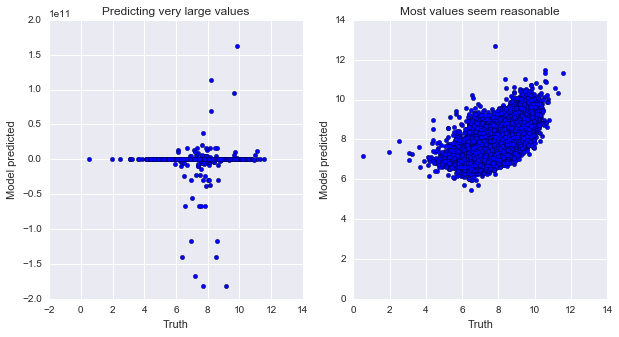

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(y_test,newmodel.predict(X_test))
plt.ylabel('Model predicted')
plt.xlabel('Truth')
plt.title('Predicting very large values')

plt.subplot(1,2,2)
plt.scatter(y_test,newmodel.predict(X_test))
plt.ylabel('Model predicted')
plt.xlabel('Truth')
plt.xlim([0,14])
plt.ylim([0,14])
plt.title('Most values seem reasonable')

In [16]:
print np.max(pred)
print 1.6e11

162891597113.0
1.6e+11


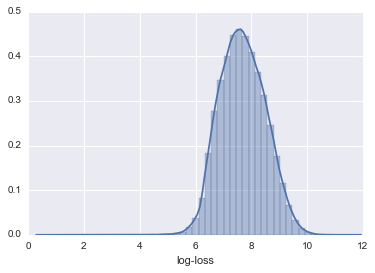

In [19]:
sns.distplot(final_data['log-loss'])